In [2]:
suppressMessages(library(scRepertoire))
suppressMessages(library(Seurat))
suppressMessages(library(tidyverse))
suppressMessages(library(ggpubr))

In [3]:
setwd("/rd2/user/xiacr/sle/")

In [4]:
load("./final/seurat/b_cell/03-b_cell_anno_filter_harm.rdata")
load("./final/scRepertoire/BCR/combined_bcr.rdata")

In [16]:
ls()

[1] "bcell_filter"         "bcell_filter_bcr"     "colorblind_vector"   
[4] "combined_bcr"         "scRepertoire_barcode"

In [6]:
# We need to handle the barcode difference between scRepertoire and seurat
# SAMPLE + GROUP + BARCODE
Cells(bcell_filter) %>% head()
scRepertoire_barcode <- bcell_filter@meta.data %>% rownames_to_column("barcode") %>% 
    mutate(new_barcode = str_split_fixed(barcode, "_", 2)[, 1]) %>%
    mutate(scRepertoire = paste0(orig.ident, "_", group, "_", new_barcode)) %>% select(scRepertoire)

bcell_filter <- RenameCells(bcell_filter, new.names = scRepertoire_barcode$scRepertoire)

[1] "GW_SLE_CAGGTGCCAGGGCATA-1" "GW_SLE_GAGGTGATCTCTTGAT-1"
[3] "GW_SLE_AACCATGCACCAGTTA-1" "GW_SLE_GGACAAGGTACATGTC-1"
[5] "GW_SLE_TACGGGCTCTCGATGA-1" "GW_SLE_CGTGTCTCATGCATGT-1"

[1] "AAACCTGCACCGCTAG-1_1" "AAACCTGCACTAAGTC-1_1" "AAACCTGGTCTCTTAT-1_1"
[4] "AAACGGGCACAGATTC-1_1" "AAACGGGGTTTGTTTC-1_1" "AAAGATGCAGTATAAG-1_1"

In [8]:
ls()

[1] "bcell_filter"         "combined_bcr"         "scRepertoire_barcode"

In [17]:
bcell_filter <- combineExpression(combined_bcr, bcell_filter,
            cloneCall = "gene+nt", group.by = "sample", proportion = FALSE,
            cloneTypes = c(Single = 1, Small = 10, Medium = 10, Large = 1000))
# bcell_filter <- combineExpression(combined_bcr, bcell_filter, 
#             cloneCall="gene", group.by = "sample", proportion = T,
#             cloneTypes = c(Rare = 1e-04, Small = 0.001, Medium = 0.01, Large = 0.1, Hyperexpanded = 1))
colorblind_vector <- colorRampPalette(rev(c("#0D0887FF", "#47039FFF",
              "#7301A8FF", "#9C179EFF", "#BD3786FF", "#D8576BFF",
              "#ED7953FF", "#FA9E3BFF", "#FDC926FF", "#F0F921FF")))

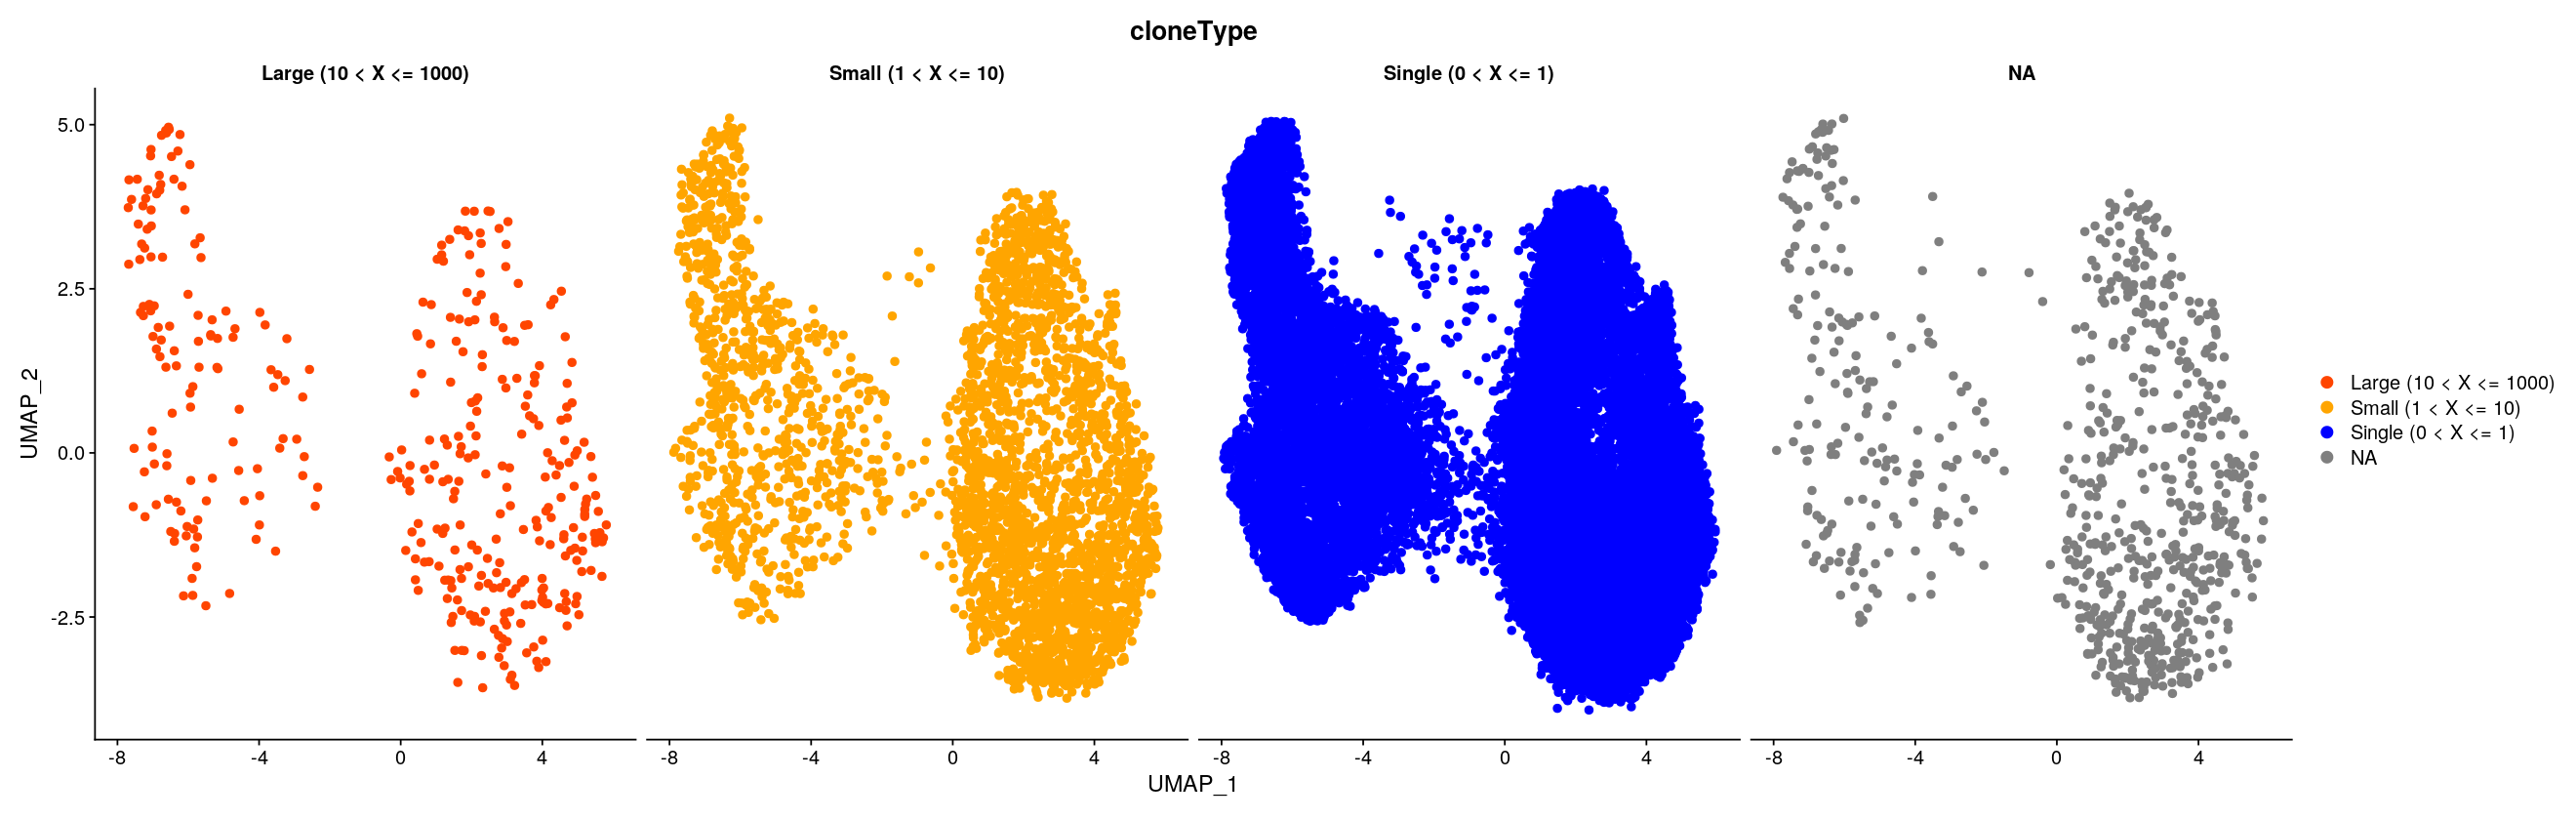

In [18]:
options(repr.plot.width = 22, repr.plot.height = 7)
slot(bcell_filter, "meta.data")$cloneType <- factor(slot(bcell_filter, "meta.data")$cloneType,
                levels = c("Large (10 < X <= 1000)",
                            "Small (1 < X <= 10)",
                            "Single (0 < X <= 1)", NA))
# slot(bcell_filter, "meta.data")$cloneType <- factor(slot(bcell_filter, "meta.data")$cloneType,
#                 levels = c("Hyperexpanded (20 < X <= 5000)", 
#                            "Large (10 < X <= 20)", 
#                             "Medium (5 < X <= 10)", 
#                             "Small (1 < X <= 5)", 
#                             "Single (0 < X <= 1)", NA))
DimPlot(bcell_filter, group.by = "cloneType", cols = rev(c("grey", "green", "blue", "#FFA500", "#FF4500")), split.by = "cloneType", pt.size = 2)

In [19]:
Idents(bcell_filter) <- "cloneType"
bcell_filter_bcr <- subset(bcell_filter, idents = c("Single (0 < X <= 1)", "Small (1 < X <= 10)"))
bcell_filter_bcr$cloneType_group <- paste0(bcell_filter_bcr$treatment, "-", bcell_filter_bcr$cloneType)
bcell_filter_bcr$cloneType_group  %>% table()

.
       HC-Single (0 < X <= 1)        HC-Small (1 < X <= 10) 
                         3349                           434 
  treated-Single (0 < X <= 1)   treated-Small (1 < X <= 10) 
                         4230                           701 
untreated-Single (0 < X <= 1) untreated-Small (1 < X <= 10) 
                        11013                          2058 

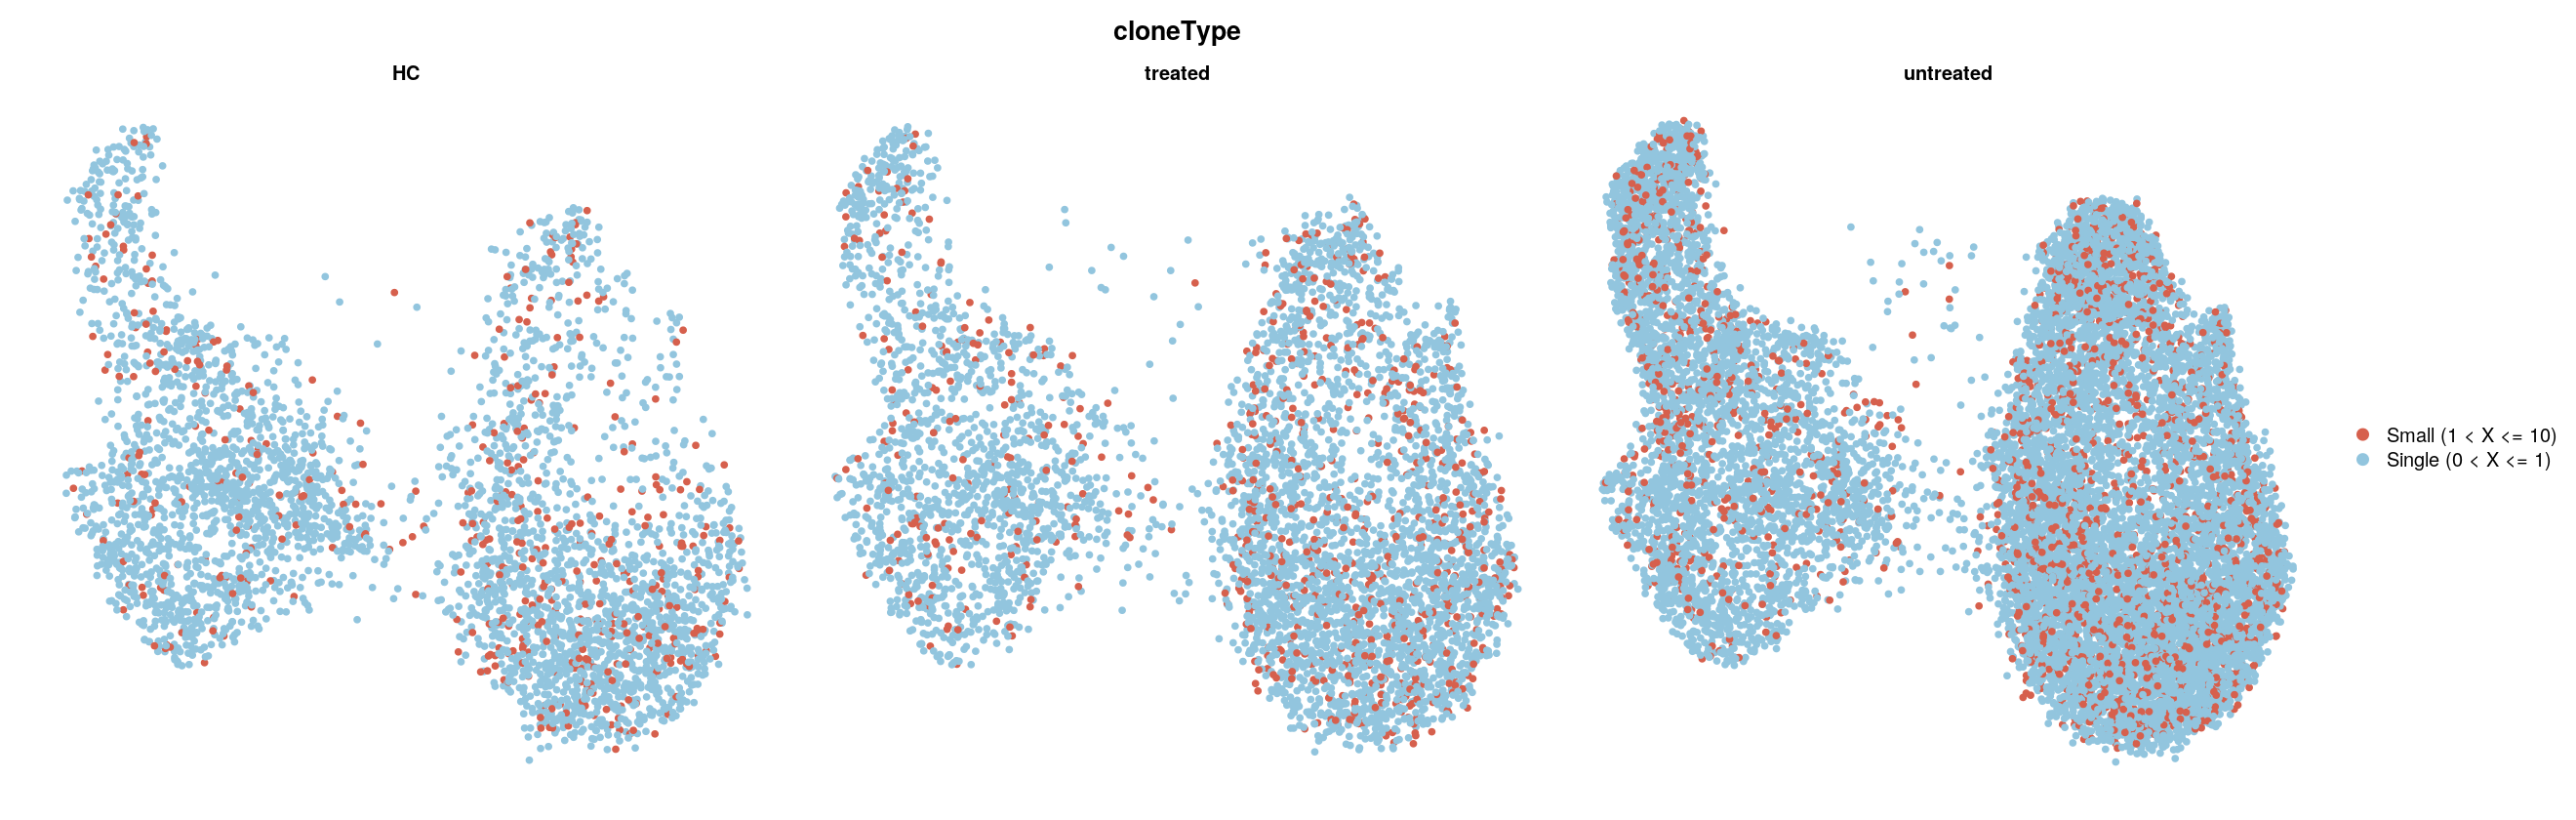

In [26]:
DimPlot(bcell_filter_bcr, group.by = "cloneType", cols = rev(c("#92C5DE", "#D6604D")), split.by = "treatment", pt.size = 1.5) + NoAxes()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



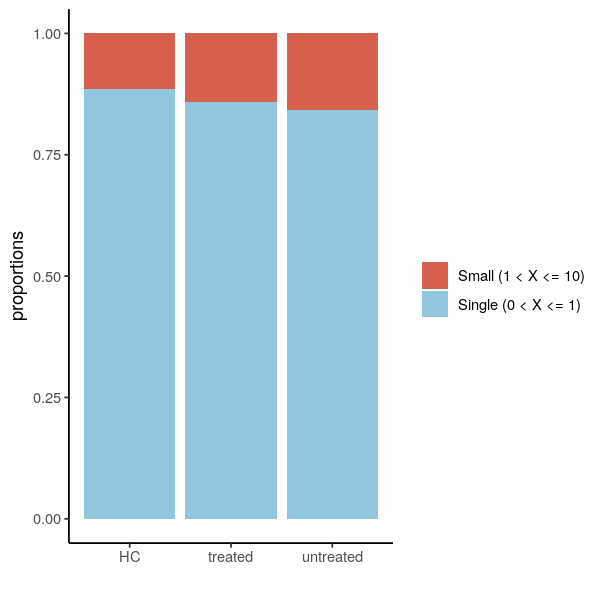

In [28]:
options(repr.plot.width = 5, repr.plot.height = 5)
ggplot(data = bcell_filter_bcr@meta.data, aes(x = treatment, fill = cloneType)) +
    geom_bar(stat = "count", position = "fill") + labs(y = "proportions", x = "") +
    scale_fill_discrete(labels = names(table(bcell_filter$cloneType))) + xlab("") +
    labs(fill = "") +  scale_fill_manual(values = rev(c("#92C5DE", "#D6604D"))) + theme_classic()

Joining, by = "orig.ident"


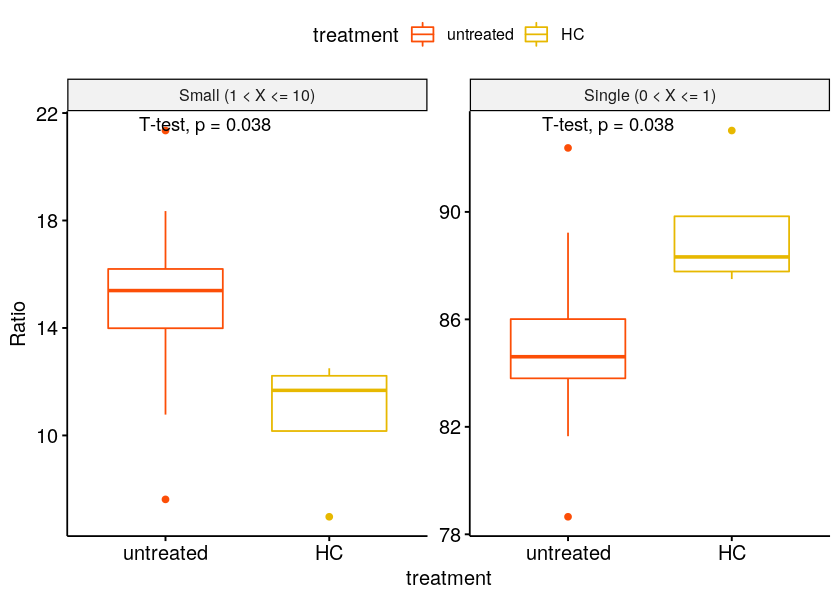

In [29]:
options(repr.plot.width = 7, repr.plot.height = 5)
bcell_filter_bcr@meta.data  %>% group_by(orig.ident,cloneType) %>% 
    summarise(sub_num = n()) %>% mutate(sample_num = sum(sub_num)) %>% 
    mutate(Ratio = sub_num / sample_num * 100) %>%
    left_join(bcell_filter_bcr@meta.data[, c(1, 4, 5, 6)] %>% distinct()) %>%
    filter(treatment != "treated") %>%
    ggpubr::ggboxplot(x = "treatment", y = "Ratio", color = "treatment",
                      palette = c("#FC4E07", "#E7B800", "#00AFBB")) +
    facet_wrap(~cloneType, scales = "free", ncol = 4) + stat_compare_means(method = "t.test")

Joining, by = "orig.ident"
Joining, by = "orig.ident"
Warning message:
“Computation failed in `stat_compare_means()`:
arguments imply differing number of rows: 0, 1”


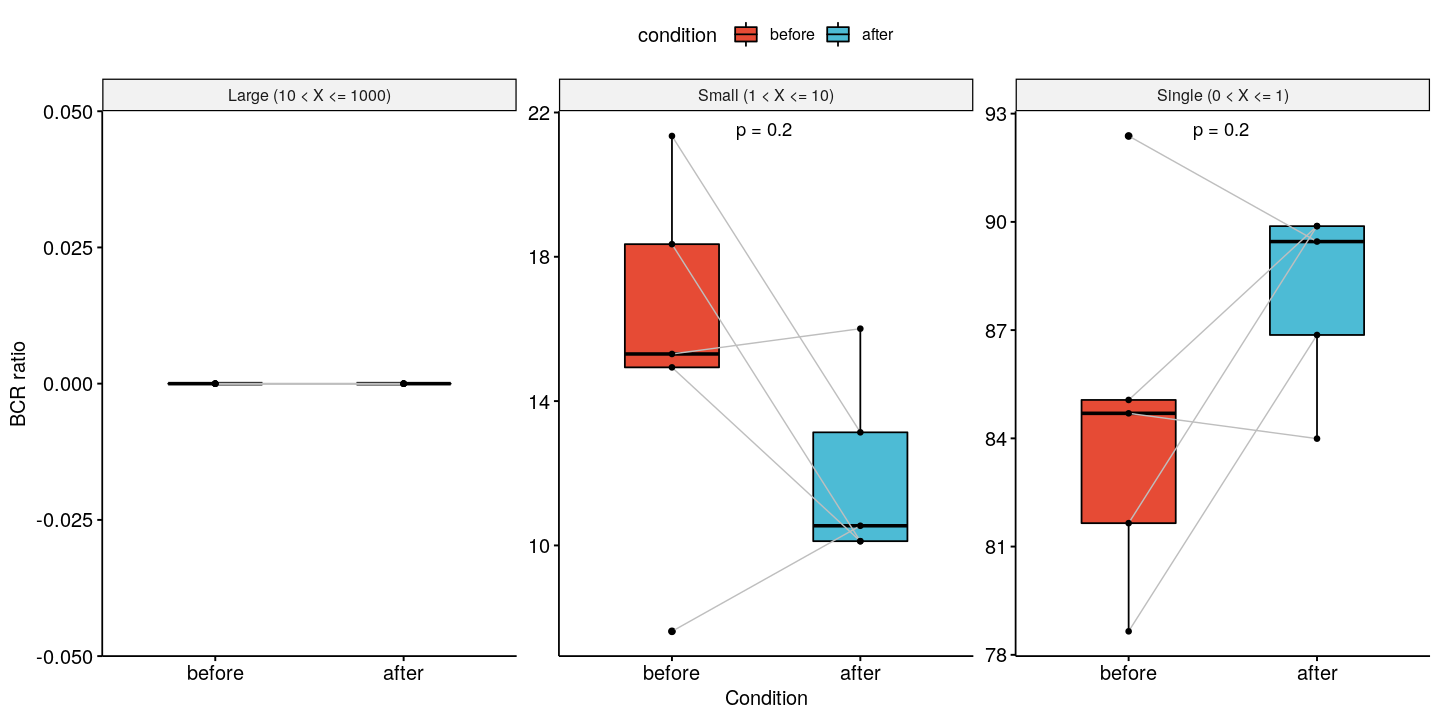

In [31]:
options(repr.plot.width = 12, repr.plot.height = 6)
tmp1 <- bcell_filter_bcr@meta.data %>%
    group_by(orig.ident,cloneType, .drop = FALSE) %>% summarise(sub_num = n()) %>%
    mutate(sample_num = sum(sub_num)) %>% mutate(Ratio = sub_num/sample_num*100) %>%
    left_join(bcell_filter@meta.data[, c(1, 4, 5, 6)]  %>%  distinct()) %>%
    filter(!pair == "unpaired") %>% filter(treatment == "treated") %>% 
    filter(!orig.ident == "XYY2")
tmp2 <- bcell_filter_bcr@meta.data  %>%
    group_by(orig.ident, cloneType,.drop = FALSE) %>% summarise(sub_num = n()) %>% 
    mutate(sample_num = sum(sub_num)) %>% mutate(Ratio = sub_num / sample_num * 100) %>%
    left_join(bcell_filter@meta.data[, c(1, 4, 5, 6)]  %>%  distinct()) %>%
    filter(!pair == "unpaired") %>% filter(treatment == "untreated") %>%
    filter(!orig.ident == "XYY2")
data.frame(sample = tmp1$orig.ident, subtype = tmp1$cloneType,
           before = tmp2$Ratio, after = tmp1$Ratio) %>%
    # mutate(across(subtype,factor, levels = c("B.transition", "B.naive", "B.IFN-response",
    #                                          "B.mem.IGHM+", "B.mem", "B.mem.CXCR3+", "B.mem.CD27-"))) %>%
    ggpaired( cond1 = "before", cond2 = "after",
              fill  = "condition", line.color = "gray", line.size = 0.4,
              palette = "npg") +  stat_compare_means(paired = TRUE, method = "t.test", label.x = 1.4, label = "p.format") +
    ylab("BCR ratio") + facet_wrap(~subtype, scales = "free", ncol = 4)

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


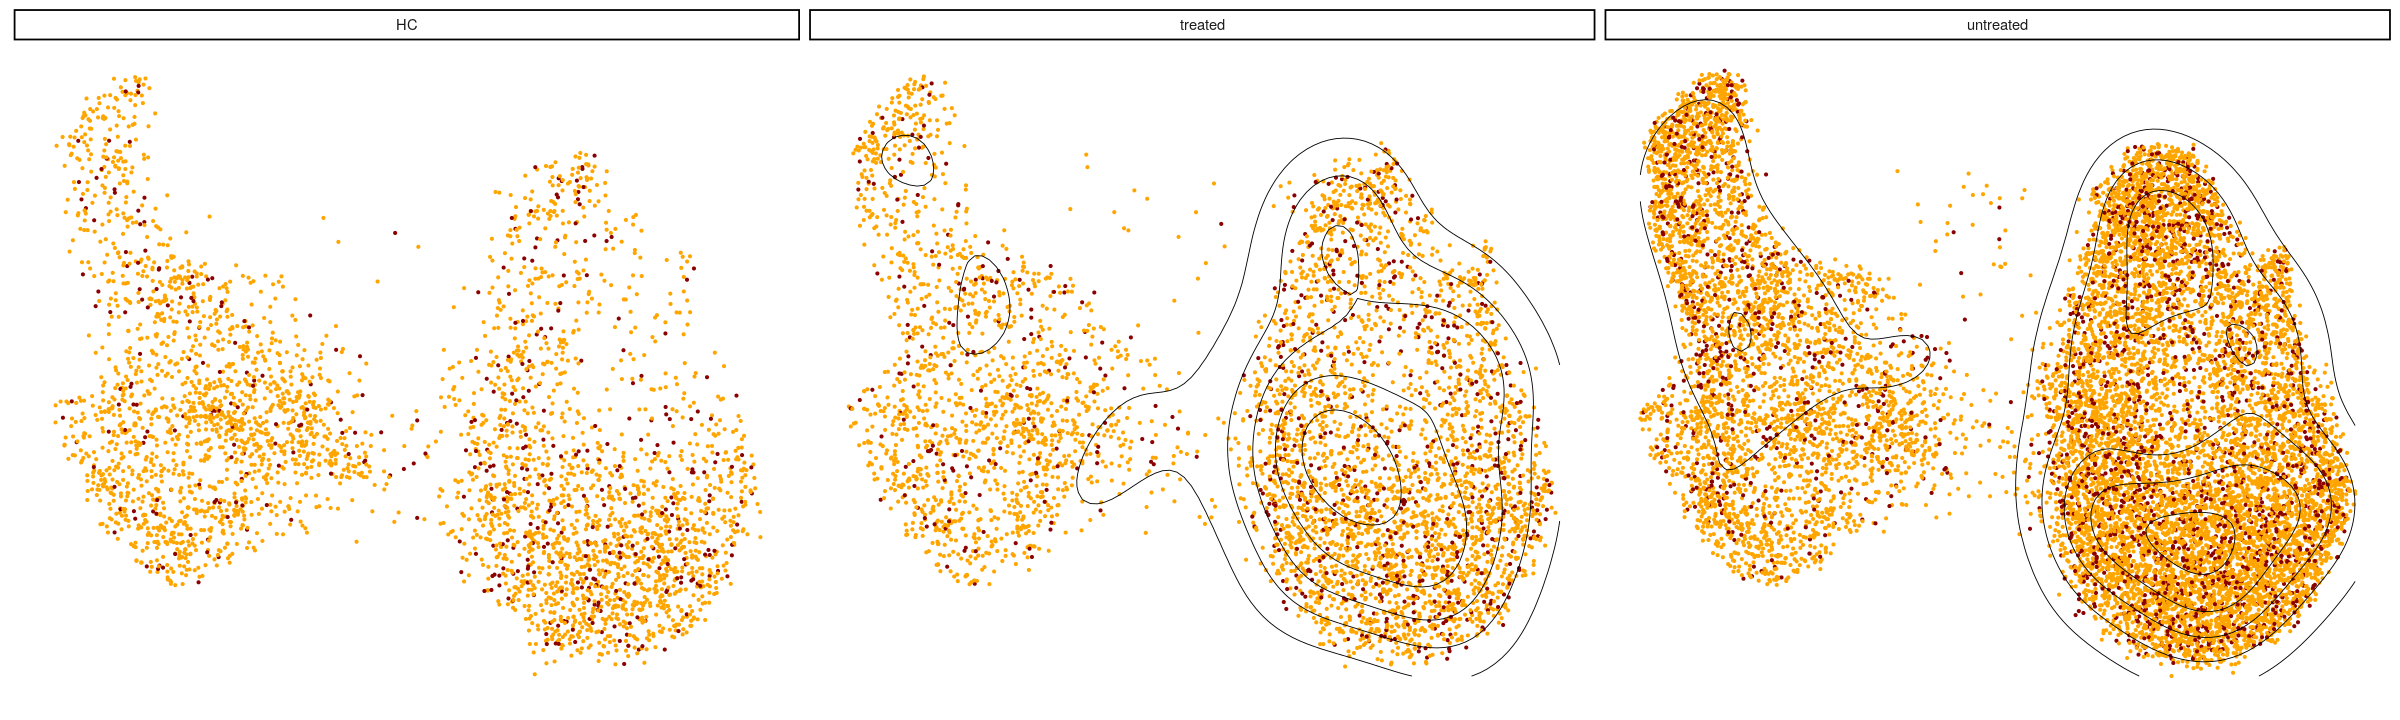

In [32]:
# Idents(bcr_plasma) <- "cloneType"
options(repr.plot.width = 20, repr.plot.height = 6)
clonalOverlay(bcell_filter_bcr, reduction = "umap",
              freq.cutpoint = 7, bins = 6, facet = "treatment") +
    guides(color = FALSE) + scale_color_manual(values = rev(c("#AFEEEE", "#FFA500", "#8B0000"))) + NoAxes()


In [133]:
bcell_filter$CTaa %>% is.na() %>% table()

.
FALSE  TRUE 
22159   724 

# SHM sample

In [134]:
SHM_info <- read.csv("./scripts/immcantaion/bcell_immacantation_SHM.csv")
SHM_info$barcode <- str_split_fixed(SHM_info$sequence_id, pattern = "_", n = 2)[, 1] %>%
    paste0("_", SHM_info$sample)

In [135]:
bcell_filter$barcode_shm <- paste0(str_split_fixed(Cells(bcell_filter), pattern = "_", n = 3)[ ,3], "_",bcell_filter$orig.ident)

In [136]:
intersect(SHM_info$barcode, bcell_filter$barcode_shm) %>% length()

[1] 20892

In [137]:
shm_df <- bcell_filter@meta.data %>% left_join(SHM_info, by = c("barcode_shm" = "barcode")) %>%
    drop_na(mu_freq_seq_r) %>% drop_na(Frequency)

In [166]:
shm_df$cloneType %>% table()

.
Large (10 < X <= 1000)    Small (1 < X <= 10)    Single (0 < X <= 1) 
                     0                    254                  20638 

Warning message:
“Ignoring unknown parameters: trim”


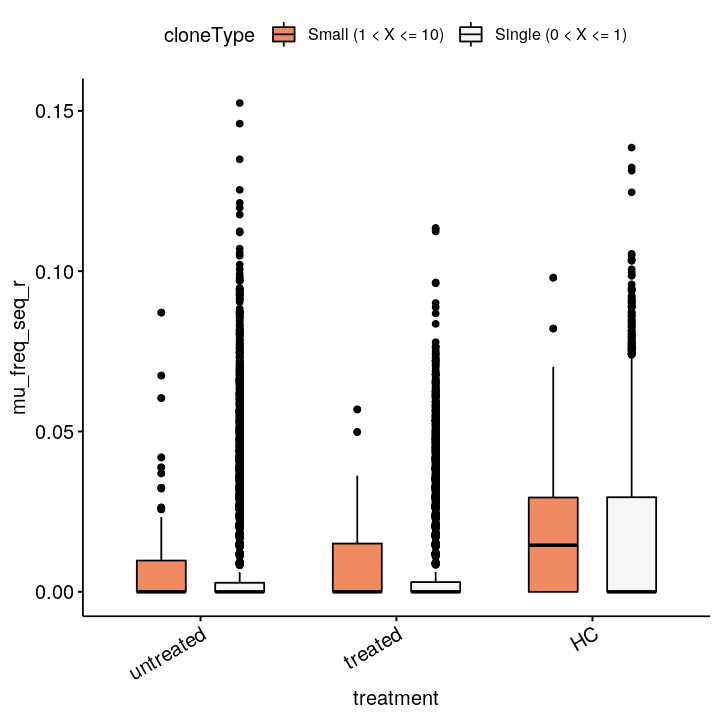

In [198]:
options(repr.plot.width = 6, repr.plot.height = 6)
compare_group <-  list(c("HC", "untreated"), c("treated", "untreated"), c("HC", "treated"))
shm_df  %>%
# filter(Frequency !=1) %>%
ggboxplot(x = "treatment", y = "mu_freq_seq_r", fill = "cloneType", trim = T, width = 0.5, palette = "RdBu")   +
    # stat_compare_means(mapping = aes(treatment),label = "p.signif",hide.ns = F) +
    # stat_compare_means(mapping = aes(treatment),label = "p.signif",hide.ns = F,comparisons =compare_group) +
    theme(axis.text.x = element_text(angle = 30, hjust = 1), )

# scRepertiore diversity  

In [152]:
combined_bcr <- addVariable(combined_bcr, name = "group",
                       variables = c("before", "before", "before", "after", "before", "before", "before", "after", "before", "HC", "before",
                                     "before", "after", "before", "before", "after", "after", "HC", "HC", "before", "after", "HC"))

In [154]:
options(repr.plot.width = 12, repr.plot.height = 6)
clonalHomeostasis(bcell_filter_bcr, cloneCall = "aa", split.by = "group")

ERROR: Error in clonalHomeostasis(bcell_filter_bcr, cloneCall = "nt", split.by = "group"): unused argument (split.by = "group")


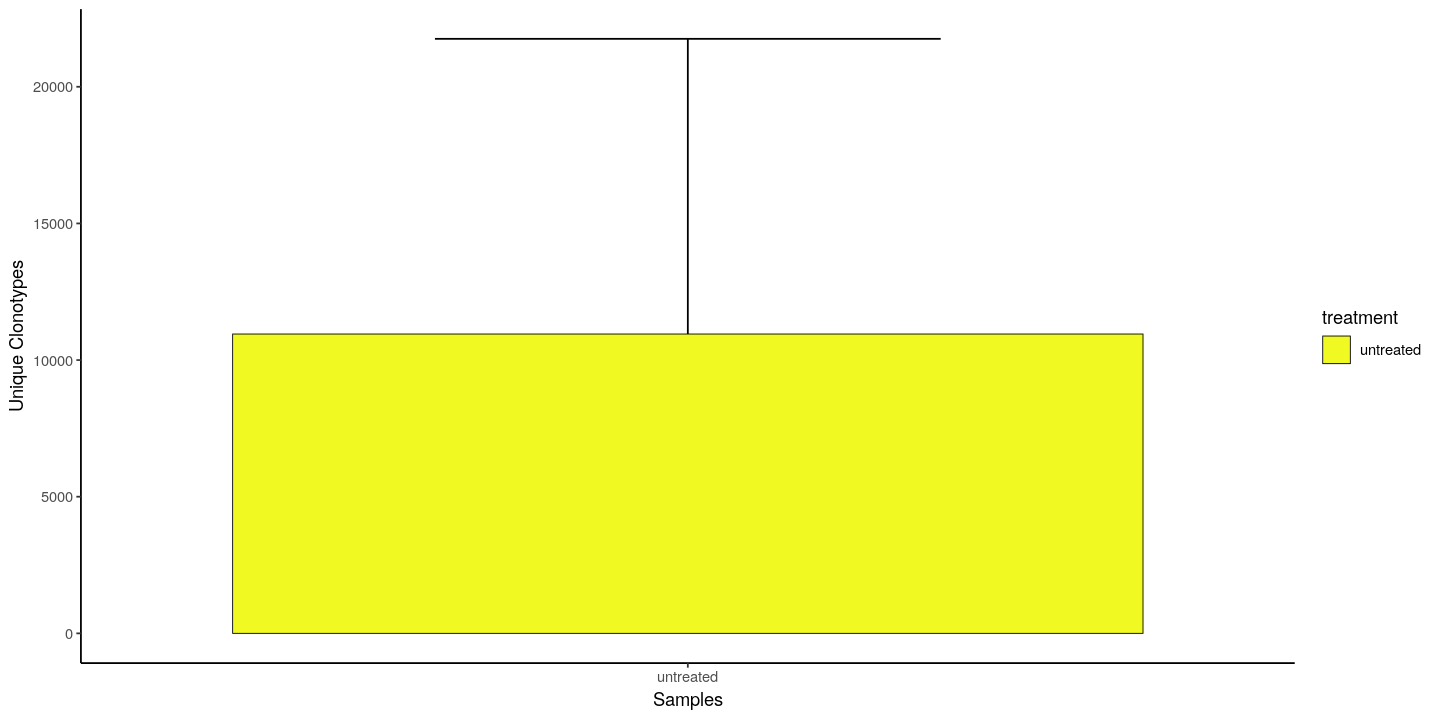

In [158]:
quantContig(bcell_filter_bcr, cloneCall = "aa", group.by = "treatment")